### *Juho Laitala*

# Introduction

This notebook shows workflow used to train long short-term memory network (LSTM) to detect R-peaks from the electrocardiography (ECG) signals. Model is created with TensorFlow 2.0 by using high level Keras API while it is trained by using [MIT-BIH Arrhythmia](https://physionet.org/content/mitdb/1.0.0/) and [MIT-BIH Noise Stress Test databases](https://physionet.org/content/nstdb/1.0.0/). Model takes 1000 sample points of nonfiltered ECG with sampling frequency of 250 Hz as input and returns probabilites for each sample point being an R-peak.

In [1]:
# Importing needed libraries
from matplotlib import pyplot as plt
from ecg2rr import data
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly

# Data sets

## MIT-BIH Arrhythmia

MIT-BIH Arrythmia dataset was created in 1980 by Boston's Beth Israel Hospital for the arrhytmia analysis purposes. It contains 48 half-hour two channel ambulatory ECG recordings that were obtained from 47 subjects. Records were digitized by using sampling frequency of 360 Hz. Modified limb lead II (MLII) from all recordings is used to train the model.

## MIT-BIH Noise Stress Database

MIT-BIH Noise Stress Database was created for assessing the performance of arrhytmia detectors for noisy signals. It contains 12 half-hour ECG recordings and 3 half-hour recordings of typical noise (baseline wander, muscle artifact and electrode motion artifact) in ambulatory ECG recordings. Only baseline wander and muscle artifact recordings are used in model training.

## Loading data


In [2]:
mitdb_records = get_record_list('mitdb')
mitdb_signals, mitdb_beats, mitdb_beat_types = data.data_from_records(mitdb_records, channel=0, db='mitdb')

processing record:  100
processing record:  101
processing record:  102
processing record:  103
processing record:  104
processing record:  105
processing record:  106
processing record:  107
processing record:  108
processing record:  109
processing record:  111
processing record:  112
processing record:  113
processing record:  114
processing record:  115
processing record:  116
processing record:  117
processing record:  118
processing record:  119
processing record:  121
processing record:  122
processing record:  123
processing record:  124
processing record:  200
processing record:  201
processing record:  202
processing record:  203
processing record:  205
processing record:  207
processing record:  208
processing record:  209
processing record:  210
processing record:  212
processing record:  213
processing record:  214
processing record:  215
processing record:  217
processing record:  219
processing record:  220
processing record:  221
processing record:  222
processing recor

## Different R-peak types

In the following lines of code the different types of heart beats (R-peaks) in the data set are shown. It can be seen that the normal beats are by far the most common beat type.

In [3]:
# Extract beat symbols from all records
all_symbols = []
for symbols in mitdb_beat_types:
    all_symbols.append(symbols)
    
all_symbols = [item for sublist in all_symbols for item in sublist]
all_symbols = np.asarray(all_symbols)
u, c = np.unique(all_symbols, return_counts=True)

# Meanings for different heart beat codings
label_meanings = {
    "N": "Normal beat",
    "L": "Left bundle branch block beat",
    "R": "Right bundle branch block beat",
    "V": "Premature ventricular contraction",
    "/": "Paced beat",
    "A": "Atrial premature beat",
    "f": "Fusion of paced and normal beat",
    "F": "Fusion of ventricular and normal beat",
    "j": "Nodal (junctional) escape beat",
    "a": "Aberrated atrial premature beat",
    "E": "Ventricular escape beat",
    "J": "Nodal (junctional) premature beat",
    "Q": "Unclassifiable beat",
    "e": "Atrial escape beat",
    "S": "Supraventricular premature or ectopic"
}

# Print number of instances in each beat type
label_counts = [(label, count) for label, count in zip(u.tolist(), c.tolist())]
label_counts.sort(key=lambda tup: tup[1], reverse=True)
for label in label_counts:
    print(label_meanings[label[0]], "-"*(40-len(label_meanings[label[0]])), label[1])

Normal beat ----------------------------- 75052
Left bundle branch block beat ----------- 8075
Right bundle branch block beat ---------- 7259
Premature ventricular contraction ------- 7130
Paced beat ------------------------------ 7028
Atrial premature beat ------------------- 2546
Fusion of paced and normal beat --------- 982
Fusion of ventricular and normal beat --- 803
Nodal (junctional) escape beat ---------- 229
Aberrated atrial premature beat --------- 150
Ventricular escape beat ----------------- 106
Nodal (junctional) premature beat ------- 83
Unclassifiable beat --------------------- 33
Atrial escape beat ---------------------- 16
Supraventricular premature or ectopic --- 2


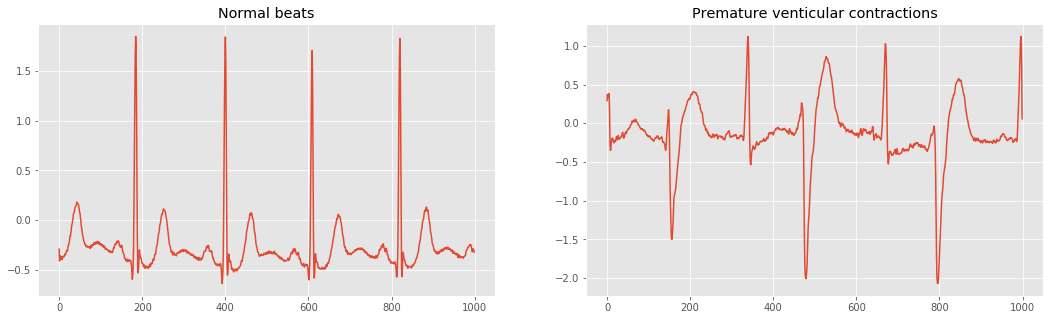

In [4]:
# Plot examples of beat types
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5), fig.set_figwidth(18)
ax1.plot(mitdb_signals[3][:1000])
ax1.set_title('Normal beats')
ax2.plot(mitdb_signals[23][:1000])
ax2.set_title('Premature venticular contractions')
plt.show()


## Converting character encodings to numerical

For model training purposes the character encodings need to be converted to numerical. To keep things simple, only normal beats are used on model training. Normal beats are encoded as ones while rest of the beat types are encoded as negative ones. Other beats are not used in training because some of the heart beat types have very irregular forms and for some beat types "R-peak" can be pointing downwards instead upwards.

Even thought only normal beats are selected, some of the "R-peaks" can still be facing downwards (see figure below). Helper function `fix_labels` was created to fix this issue. It changes peak label to -1 if peak doesn't occur at the local maxima.

In [5]:
# Create dictionary that encodes characters as numerical
label_codings = {}
for i in range(0, len(label_counts)):
  if label_counts[i][0] == 'N':
    label_codings[label_counts[i][0]] = 1
  else:
    label_codings[label_counts[i][0]] = -1
label_codings

{'N': 1,
 'L': -1,
 'R': -1,
 'V': -1,
 '/': -1,
 'A': -1,
 'f': -1,
 'F': -1,
 'j': -1,
 'a': -1,
 'E': -1,
 'J': -1,
 'Q': -1,
 'e': -1,
 'S': -1}

In [6]:
# Save new numerical encodings as list
mitdb_labels = []
for beat_types in mitdb_beat_types:
    numerical_symbols = [label_codings[sym] for sym in beat_types]
    mitdb_labels.append(np.asarray(numerical_symbols))
    
mitdb_labels[:5]

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1, -1, ..., -1, -1, -1])]

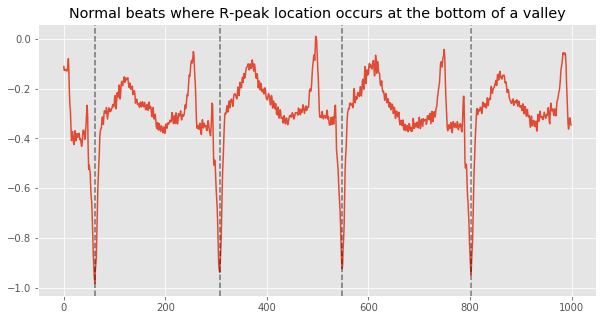

In [7]:
# Plot signal and beat locations as dashed line
plt.figure(figsize=(10,5))
plt.plot(mitdb_signals[8][:1000])
for peak in mitdb_beats[8][:4]:
    plt.axvline(x=peak, color='k', linestyle='--', alpha=0.5)
plt.title('Normal beats where R-peak location occurs at the bottom of a valley')
plt.show()

In [8]:
mitdb_labels = data.fix_labels(mitdb_signals, mitdb_beats, mitdb_labels)

# Building the model

## Intorduction

Data augmentation is perhaps the most important step in this workflow. Training the network requires lots of data that is similar as in planned use case. In this work the planned use case is to predict R-peak locations from unfiltered and noisy ECG signals. No publicly available databases of unfiltered and noisy ECG signals with labels were found. However, one database ([MIT-BIH Noise Stress Test databases](https://physionet.org/content/nstdb/1.0.0/)) that contains examples of typical noise in ambulatory ECG recordings was found. Therefore it became possible to simulate noisy ECG signals by adding noise from the examples to the ECG signals from [MIT-BIH Arrhythmia](https://physionet.org/content/mitdb/1.0.0/) database.



## Noise

The most common noise sources in the ECG signals are:
- Baseline wandering
- Muscle artifacts
- Electrode motion artifacts
- Mains interefence

From these the electrode motion artifacts are the most challenging as they can closely mimic the beats in the ECG signal. Because of this, electrode motion artifacts are not used in training alhought the example of this noise is available in the MIT-BIH Noise Stress Test database.

Mains interefence is not available in the database and therefore it is constructed in the data augmentation phase by using `create_sine` function.

Both baseline wander and muscle artifact recording contained two separate channels. Data in these channels isn't exactly identical, and thus, longer recordings can be constructed by concatenating the two channels. In this way, more noise data from both sources can be used in training.

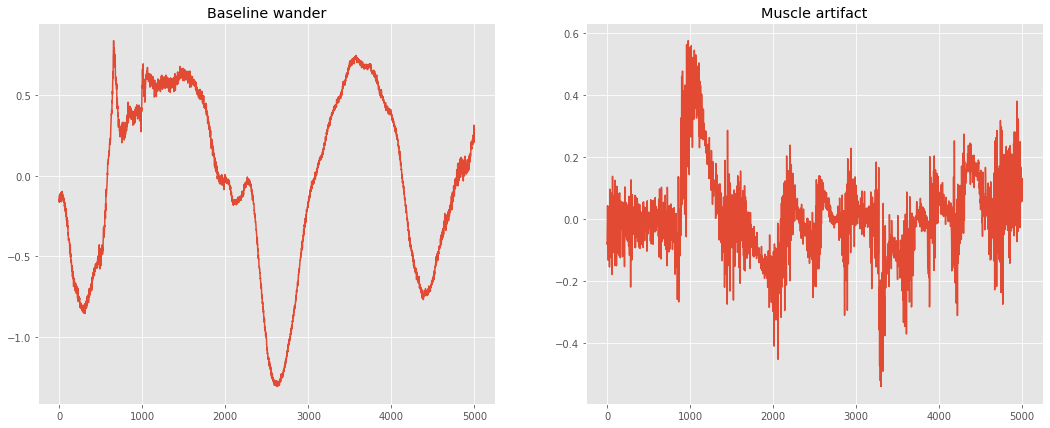

In [9]:
# Load data
baseline_wander = rdsamp('bw', pb_dir='nstdb')
muscle_artifact = rdsamp('ma', pb_dir='nstdb')

# Concatenate two channels to make one longer recording
ma = np.concatenate((muscle_artifact[0][:,0], muscle_artifact[0][:,1]))
bw = np.concatenate((baseline_wander[0][:,0], baseline_wander[0][:,1]))

# Resample noise to 250 Hz
ma = resample_poly(ma, up=250, down=muscle_artifact[1]['fs'])
bw = resample_poly(bw, up=250, down=baseline_wander[1]['fs'])

# Plot examples of baseline wandering and muscle artifact noise types
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7), fig.set_figwidth(18)
ax1.plot(bw[:5000])
ax1.set_title('Baseline wander')
ax2.plot(ma[:5000])
ax2.set_title('Muscle artifact')
plt.show()

## Data augmentation

Heart of the data augmentation phase is the `generator` function which yields batches of labeled training examples. Generator function uses helper function `get_noise` to retrieve noise to be added to the ECG signal. `get_noise` function in turn uses `create_sine` function to retrieve mains interefence noise. Randomization is purposefully used in every step to maximize the number of differing training examples.

Only sections of the signals that don't contain other than normal beats are allowed to act as training examples. Labeling is done so that original indices that correspond to the peak locations and two indices next to original indices are labeled as ones while rest of the indices are labeled as zeros. In this way the data set becomes slightly more balanced and this kind of labeling can be also be utilized to reduce the number of false positives when model predictions are processed.

## Examples of the training data

Below are few examples of the training data and labels that are produced by the data generator. One is added to all label values to separate them from the noisy ECG signals.

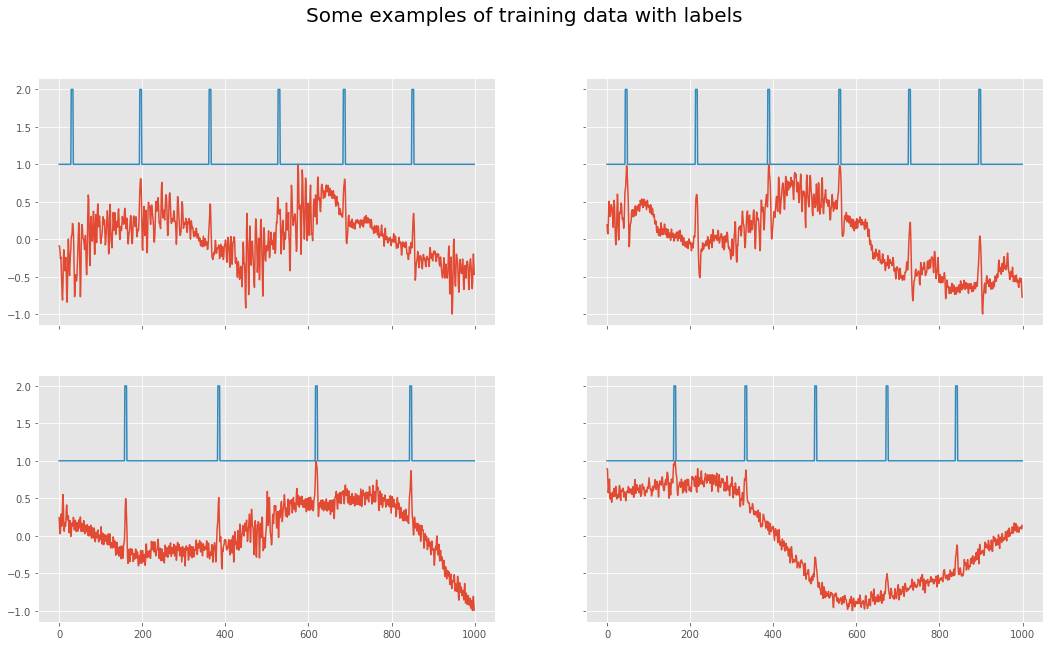

In [10]:
# Test noise generator
gen = data.ecg_generator(mitdb_signals, mitdb_beats, mitdb_labels, ma, bw, win_size=1000, batch_size=4)
n = next(gen)

# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=20)

axs[0, 0].plot(n[0][0])
axs[0, 0].plot(n[1][0]+1)
axs[0, 1].plot(n[0][1])
axs[0, 1].plot(n[1][1]+1)
axs[1, 0].plot(n[0][2])
axs[1, 0].plot(n[1][2]+1)
axs[1, 1].plot(n[0][3])
axs[1, 1].plot(n[1][3]+1)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Creating and training LSTM model

Sequence to sequence model is used to predict R-peak locations. Model takes 1000 time steps of ECG signal as input which are then mapped to 1000 probability values. Each probability value indicates the probability that the particular time step is an R-peak



Model is trained 150 epochs with `steps_per_epoch` of 40 and a batch size of 256.

In [11]:
# Create training data generator
n_batch, n_timesteps, n_input_dim = 256, 1000, 1
training_gen = data.ecg_generator(mitdb_signals, mitdb_beats, mitdb_labels, ma, bw, win_size=n_timesteps, batch_size=n_batch)

# Create sequential model and add layers to it
model = tf.keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [27]:
# train model
model.fit_generator(training_gen,
          steps_per_epoch=40,
          epochs=150,
          use_multiprocessing=True)

Epoch 1/150
40/40 [==============================] - 26s 661ms/step - loss: 0.2493 - acc: 0.8955
Epoch 2/150
40/40 [==============================] - 26s 644ms/step - loss: 0.0956 - acc: 0.9750
Epoch 3/150
40/40 [==============================] - 26s 645ms/step - loss: 0.0418 - acc: 0.9855
Epoch 4/150
40/40 [==============================] - 26s 646ms/step - loss: 0.0245 - acc: 0.9922
Epoch 5/150
40/40 [==============================] - 26s 647ms/step - loss: 0.0202 - acc: 0.9937
Epoch 6/150
40/40 [==============================] - 26s 647ms/step - loss: 0.0189 - acc: 0.9941
Epoch 7/150
40/40 [==============================] - 26s 649ms/step - loss: 0.0196 - acc: 0.9939
Epoch 8/150
40/40 [==============================] - 26s 647ms/step - loss: 0.0178 - acc: 0.9944
Epoch 9/150
40/40 [==============================] - 26s 644ms/step - loss: 0.0173 - acc: 0.9946
Epoch 10/150
40/40 [==============================] - 26s 644ms/step - loss: 0.0166 - acc: 0.9948
Epoch 11/150
40/40 [=========

In [19]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 128)         33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, 1000, 1)           129       
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________
